<img src='https://www.usc.gal/gl/info_xeral/imaxeusc/imaxes/001.gif'>

# Deep Learning
## Convolutional Neural Networks
### Gender prediction

**Students**
- Victor Barreiro Dominguez
- Maximiliano Hormazábal Lagos 

In [1]:
## Code made for using the GPU

import tensorflow as tf
import numpy as np

np.random.seed(0)
tf.random.set_seed(0)

# Obtain the list of available devices
devices = tf.config.list_physical_devices('GPU')

if len(devices) > 0:
  # Set TensorFlow to use GPU
  tf.config.set_visible_devices(devices[0], 'GPU')
  print('GPU n°:', devices[0])
else:
  print('No GPU available.')

print("Current Device:", tf.test.gpu_device_name())

2023-03-16 10:29:22.747075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 10:29:22.860571: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-16 10:29:23.301944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/victorxesus.barreiro/anaconda3/envs/deepgpu4/lib/
2023-03-16 10:29:23.301982: W tensorflow/

GPU n°: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Current Device: /device:GPU:0


2023-03-16 10:29:23.689137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 10:29:23.701338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 10:29:23.701410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 10:29:23.702128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

# Loading data

In [2]:
# Dataset path
from os import listdir
import os.path

PATH = './faces_dataset_train/'
PATH_TEST = './faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

### Metadata access

In [3]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


In [4]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

2023-03-16 10:29:24.319986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 10:29:24.320087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 10:29:24.320127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 10:29:24.320191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 10:29:24.320230: I tensorflow/compiler/xla/stream_executo

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Image shape:  (32, 32, 3)
Label:  1


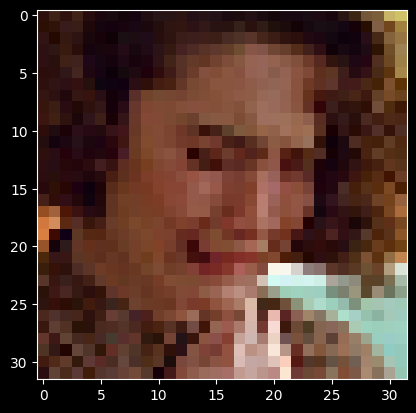

Image shape:  (32, 32, 3)
Label:  0


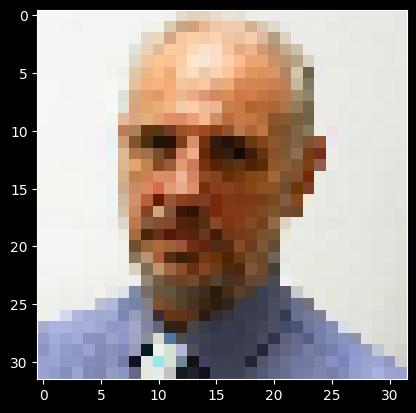

Image shape:  (32, 32, 3)
Label:  0


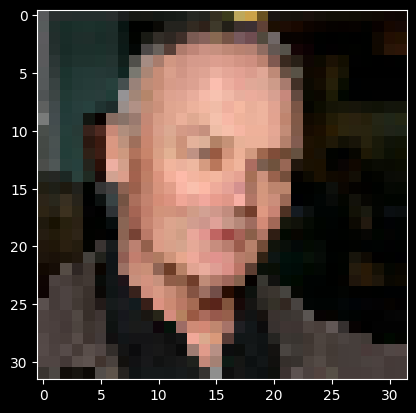

Image shape:  (32, 32, 3)
Label:  0


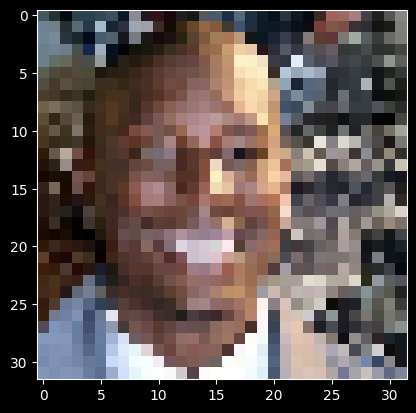

Image shape:  (32, 32, 3)
Label:  1


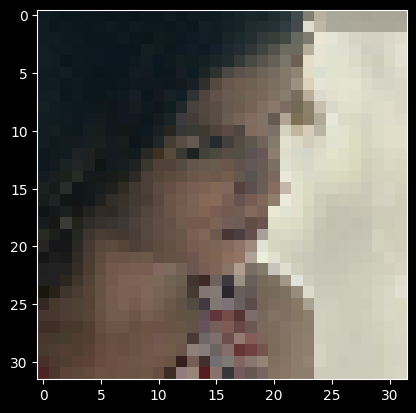

In [5]:
import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

# def process_path_age(file_path):
#     '''Transforma cadenas de la forma 'ruta|edad|genero' a tuplas (imagen, etiqueta)
#     '''
#     parts = tf.strings.split(file_path, '|')
#     age = parts[1]
#     age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
#     gender = parts[2]
#     # Load the raw data from the file as a string
#     img = tf.io.read_file(parts[0])
#     img = decode_img(img)
#     return img, age

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    print(parts)
    gender = tf.cast(0 if parts[2] == 'M' else 1, tf.dtypes.int32)
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, gender

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    pyplot.imshow(image.numpy())
    pyplot.show()

## Data Transformation

In [6]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

# OPTIONAL: sample gender weights
# import numpy as np
# labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
# freqs = np.array([1. - np.mean(labels), np.mean(labels)])
# i_freqs = 1. / freqs
# sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
# print(sample_weights)
# ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
# ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))

batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

./faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Funciones auxiliares

In [7]:
from keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import Input, Model
from keras.utils import plot_model

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np

dir = "models/"

def visualize_fit(history):
    """Procedure to print de evolution of a training process.

    Args:
        history (dict): _description_
    """    
    history_dict = history.history
    history_dict.keys()

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, 'b-o', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r-o', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    plt.plot(epochs, acc, 'b-o', label='Training acc')
    plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0.8, 1])
    plt.legend()

    plt.tight_layout()
    plt.show()

def fitModel(model, ds_train, ds_val, num_epochs=20, monitor='val_accuracy', model_name='best_model.h5', callbacks=[]):
    checkpoint = ModelCheckpoint(dir+model_name, save_best_only=True, save_weights_only=False, monitor=monitor, mode='auto', verbose=1)
    history = model.fit(ds_train, verbose = 1, epochs=num_epochs, callbacks=callbacks+[checkpoint], validation_data=ds_val)
    result = model.evaluate(ds_val)
    print(result)
    visualize_fit(history)
    return result

# Results summary

| Name         | Convolutions    | Amouny Pooling layer | Amount of parameters | Fully conected | Amount Batch N.| Epochs | Loss    | Accuracy |
|:-------------|:----------------| :-------------------:| :-------------------:| --------------:| :-------------:| :-----:| :------:| :-------:|
| test_model   | [64,128]        | 1                    | 211,905              | No             | 2              | 30     | 0.3558  | 0.8680   |
| short_model  | [8, 8, 16]      | 2                    | 6,689                | [8]            | 3              | 70     | 0.3725  | 0.8679   |
| medium_model | [32,64,256]     | 2                    | 241,897              | [8]            | 3              | 70     | 0.3361  | 0.8799   |
| big_model    | [256,512,2048]  | 2                    | 11,814,673           | [16]           | 3              | 30     | 0.3195  | 0.8740   |

### Architecture design

To solve this problem our proposal is a convolutional network, which acts as a feature extractor, and a dense layer, which is in charge of classification. Considering this from the design point of view, since we cannot assign clear responsibilities in this architecture. 

Our strategy was to obtain a first general design that obtained good results and to test and adjust to improve the results.

#### Feature Extractor
This part of the network is always composed of three convolutions, we must take into account that the images are of a very small size 32x32. After each of the convolutions we include a batch Normalization layer as a regularization strategy to try to make the network generalize better. 

Similarly after the second and third normalization layers we introduce pooling layers, namely average. We have tried maxpooling, which is usually the usual recommendation, but we obtained slightly worse results 2-3 %. This may be due to the fact that in our case there is no particularly defining aspect that we can take as a maximum in this pooling and the average or trend of the data of the previous layer provides more information. 

In both the convolutional and dense layers we have disabled the bias, since the data we introduce to the network are normalized and we are introducing normalization layers. If we were to introduce a bias and a normalization layer in which we have centering active, we would be learning two parameters whose behavior on the data would be the same, a displacement, which means an increase in complexity and possible inconsistencies. 

Regarding the filters of the convolutional layers, our strategy is to increase their number, since we should be extracting new features. In the case of the smallest network the first two convolutions have the same size because in both of them it is small, anyway it is not a remarkable anomaly since between these first two layers there is no pooling layer. In general, it may be striking that there is no pooling layer between the first and second convolution, the reason is that by having such a small input image the output of the feature extractor would be very small and in the tests performed we obtain better performance without it. 

#### Dense layers

Although we have tested incorporating several dense layers, we have not found any improvement in performance and there is a very high increase in the number of parameters to train and training times. Therefore, we have remained with a single dense layer, which for the small and medium design has 8 neurons and for the large one 16, we understand that to obtain an output with a larger size, in this case it is advisable to have a greater number of units to compute the classification. 


#### Hyperparameters

In all the layers of the model the activation function is relu, we have tested with the sigmoid function but we do not obtain better results and the models need a higher number of epochs to reach the same results. 

Regarding the learning rate, we have been testing with binary search and a high number of epochs to choose the final parameter in each case. We have also tested the use of adaptive learning rate, present in the large size model, but we have not obtained substantial improvements, except in the case of large size, where we need a lower number of epochs to achieve the same results. 

#### Final models

In the training processes, as can be seen in the graphs, we have used a high number of epochs. But to obtain the final models we have introduced a callback that saves the model with the best performance of the accuracy metric over the validation set.

### Three sizes

As we have been testing and experimenting, we have realized that networks with very different sizes show very similar performance. We can see it in the table where the difference in validation accuracy is barely more than 1%, but we went from a model of less than seven thousand parameters to another that is just behind the 12 million. 

Our proposal is that although in this problem they show a very similar behavior, it may be that by reusing these feature extractors for the age problem they have learned different aspects that can improve the performance on this new problem.

### Other tests performed

- Without dense layers: We have tested networks in which we do not introduce dense layers after the feature extractor, however, we have not achieved an improvement in the results in this way. This strategy does not seem to us to be the most appropriate for our proposal.
- Weights in training: We have tested with weights in the training process, but again the results have not improved and since we have a large number of samples we have decided to discard this option. 
- Convolution on each pixel: Another alternative that we evaluated was the use of pixel by pixel convolutions with the idea of reducing the spectral complexity, as in the previous cases the results did not improve and since we do not have requirements in terms of computational resources we have not kept this proposal. In this same line we emphasize that this reduction in the spectrum may be negative for age, intuitively color may not have an impact on gender distinction, but it could have an impact on age. 

- Kernel size in the convolutions: We tried running convolutions with a larger kernel size, however, we saw that the results worsened slightly over the validation set, which makes sense because the size of our images is very small, only 32x32, if we scroll with the filter size, we would perform only 7 convolutions across the width, and if we keep the default offset, one pixel, we are keeping 80% in each kernel application, which gives to redundant output information in that layer. Therefore we have kept convolutions of size 3x3 and a displacement of one pixel.

- Data augmentation: We have tried data augmentation, however we did not improve the results shown and there is a significant overhead in compute time. (It seems that the available implementation gets along badly with the graphics card).

- We have tested the L1 and L2 regularization and both of them were not successful.

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 64)        1728      
                                                                 
 batch_normalization_8 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         73728     
                                                                 
 batch_normalization_9 (Batc  (None, 8, 8, 128)        512 

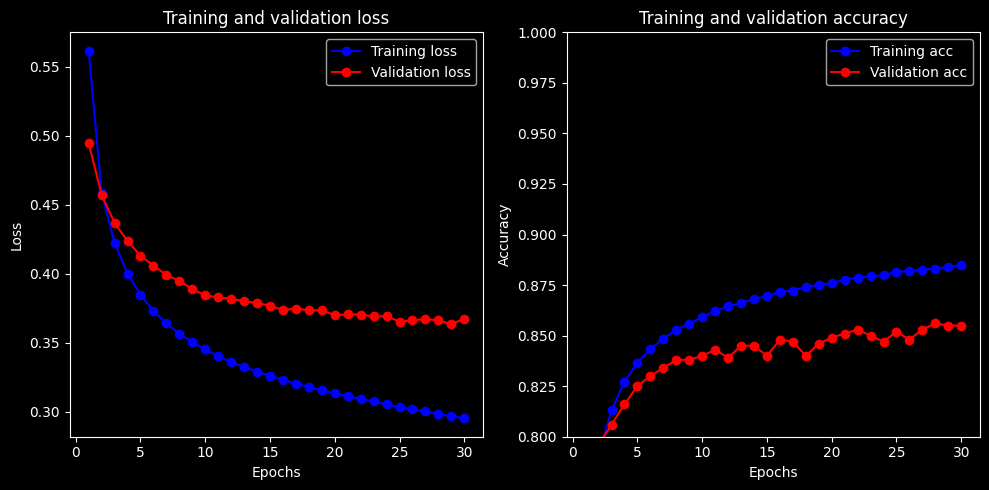

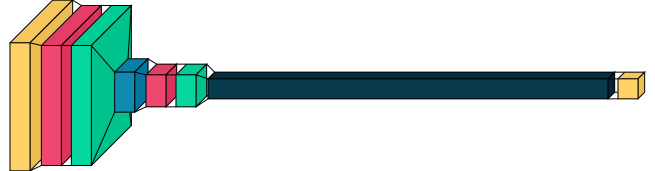

In [12]:
# test_model.h5

np.random.seed(423423)
tf.random.set_seed(1232413)

import visualkeras
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


from tensorflow.keras import layers

center = True
scale = True

input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

input = Input(shape=input_shape,name = 'Input_layer')

x = Conv2D(64, kernel_size=(3, 3), activation='relu', use_bias=False)(input)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu', use_bias=False)(x)

x = layers.BatchNormalization(center=center,scale=scale)(x)
x = Flatten(name = 'Flatten_Layer')(x)

output = Dense(1, activation='sigmoid', name = 'Output_Layer')(x)

model = Model(inputs=input,outputs=output)

model.summary()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

fitModel(model, ds_train_batch, ds_test_batch, num_epochs=30, model_name="test_model.h5")

import visualkeras
visualkeras.layered_view(model)

In [12]:
loaded_model = tf.keras.models.load_model(dir + "test_model.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 20ms/step - loss: 0.3559 - accuracy: 0.8680


[0.3558659255504608, 0.8680000305175781]

# Models

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 8)         216       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 8)         576       
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 8)        32        
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 8)        0   

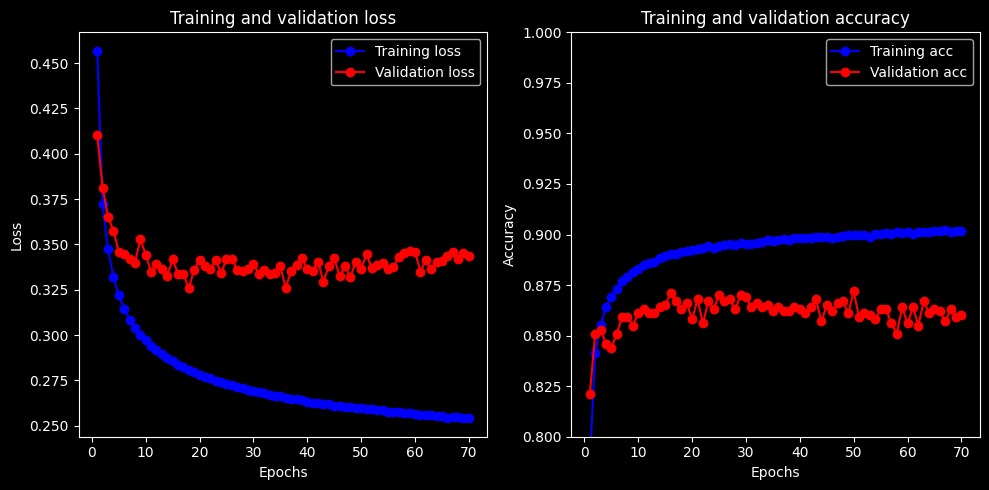

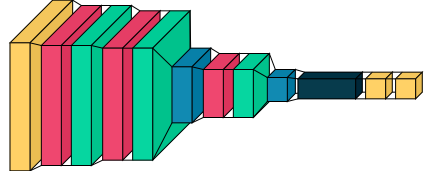

In [9]:
# short_model.h5

np.random.seed(423423)
tf.random.set_seed(1232413)

import visualkeras
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


from tensorflow.keras import layers

center = True
scale = True

input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

input = Input(shape=input_shape,name = 'Input_layer')

x = Conv2D(8, kernel_size=(3, 3), activation='relu', use_bias=False)(input)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', use_bias=False)(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', use_bias=False)(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = Flatten(name = 'Flatten_Layer')(x)

x = Dense(8, activation='relu', use_bias=False)(x)
output = Dense(1, activation='sigmoid', name = 'Output_Layer')(x)

model = Model(inputs=input,outputs=output)

model.summary()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

fitModel(model, ds_train_batch, ds_test_batch, num_epochs=70, model_name="short_model.h5")

import visualkeras
visualkeras.layered_view(model)

In [10]:
loaded_model = tf.keras.models.load_model(dir + "short_model.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 3ms/step - loss: 0.3365 - accuracy: 0.8720


[0.3364761769771576, 0.871999979019165]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18432     
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 64)       0   

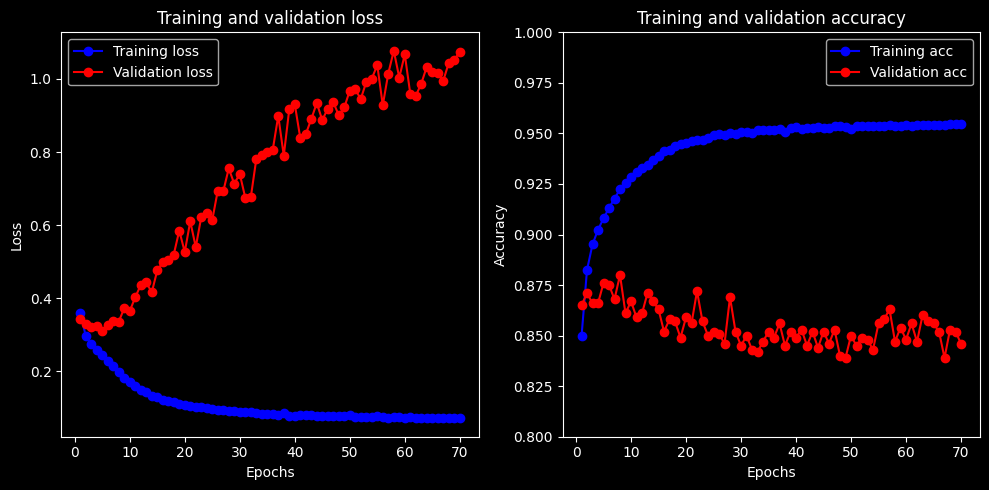

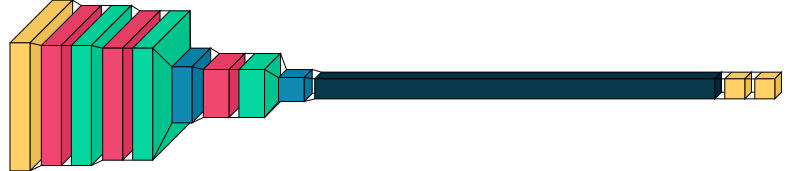

In [14]:
# medium_model.h5

np.random.seed(423423)
tf.random.set_seed(1232413)

import visualkeras
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


from tensorflow.keras import layers

center = True
scale = True

input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

input = Input(shape=input_shape,name = 'Input_layer')

x = Conv2D(32, kernel_size=(3, 3), activation='relu', use_bias=False)(input)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', use_bias=False)(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', use_bias=False)(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = Flatten(name = 'Flatten_Layer')(x)

x = Dense(8, activation='relu', use_bias=False)(x)
output = Dense(1, activation='sigmoid', name = 'Output_Layer')(x)

model = Model(inputs=input,outputs=output)

model.summary()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

fitModel(model, ds_train_batch, ds_test_batch, num_epochs=70, model_name="medium_model.h5")

import visualkeras
visualkeras.layered_view(model)

In [15]:
loaded_model = tf.keras.models.load_model(dir + "medium_model.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 3ms/step - loss: 0.3362 - accuracy: 0.8800


[0.3361859619617462, 0.8799999952316284]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       6912      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 512)       1179648   
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 512)      2048      
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 512)      0   

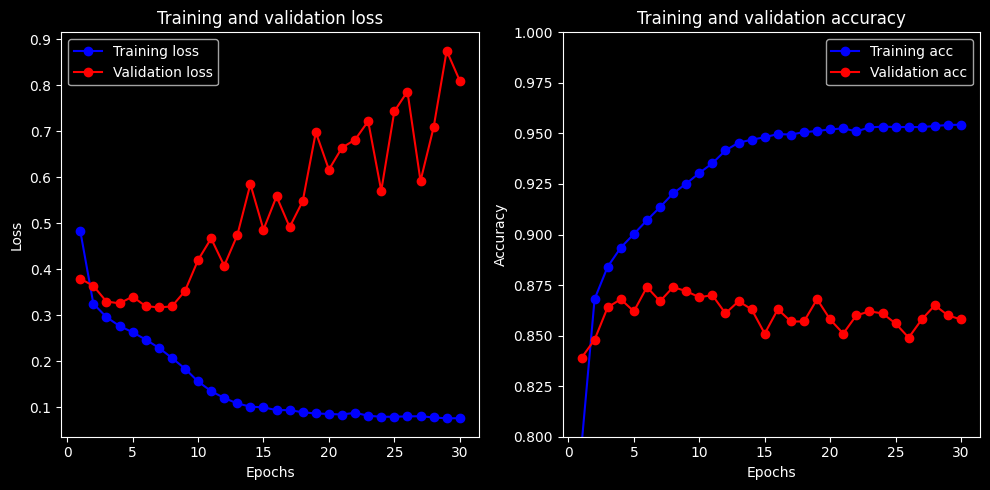

In [16]:
# big_model.h5

from keras.callbacks import ReduceLROnPlateau

# Definir un callback para reducir el learning rate si la función de pérdida se estanca
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0000001)

import time
from tensorflow.keras import layers

center = True
scale = True

input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(0.01)

input = Input(shape=input_shape,name = 'Input_layer')

x = Conv2D(256, kernel_size=(3, 3), activation='relu', use_bias=False)(input)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', use_bias=False)(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(2048, kernel_size=(3, 3), activation='relu', use_bias=False)(x)
x = layers.BatchNormalization(center=center,scale=scale)(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = Flatten(name = 'Flatten_Layer')(x)
x = Dense(16, activation='relu', use_bias=False)(x)
output = Dense(1, activation='sigmoid', name = 'Output_Layer')(x)

model = Model(inputs=input,outputs=output)

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

fitModel(model, ds_train_batch, ds_test_batch, num_epochs=30, model_name="big_model.h5", callbacks=[reduce_lr])

import visualkeras
visualkeras.layered_view(model)
time.sleep(60)  

In [17]:
loaded_model = tf.keras.models.load_model(dir + "big_model.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 11ms/step - loss: 0.3196 - accuracy: 0.8740


[0.31957584619522095, 0.8740000128746033]